In [95]:
import pandas as pd

# Load the datasets
student_vle_df = pd.read_csv('studentVle.csv')
vle_df = pd.read_csv('vle.csv')
student_info_df = pd.read_csv('studentInfo.csv')

# Only select those with code_module = 'BBB'
student_info_df = student_info_df[student_info_df['code_module'] == 'BBB']
vle_df = vle_df[vle_df['code_module'] == 'BBB']
student_vle_df = student_vle_df[student_vle_df['code_module'] == 'BBB']

# Delete students who have withdrawn
student_info_df = student_info_df[student_info_df['final_result'] != 'Withdrawn']
student_vle_df = student_vle_df[student_vle_df['id_student'].isin(student_info_df['id_student'])]

# For each student, calculate their total clicks for each type of activity. Output the result like
# student_id, clicks_forumng, clicks_glossary, clicks_homepage, clicks_oucollaborate, clicks_oucontent, clicks_ouelluminate, clicks_questionnaire, clicks_quiz, clicks_resource, clicks_sharedsubpage, clicks_subpage, clicks_url, final_result

# Join student_vle_df with vle_df to get activity types
student_activity_df = pd.merge(student_vle_df, vle_df, on=['id_site', 'code_module', 'code_presentation'])

# Group by student and activity_type, then sum clicks
activity_clicks_df = student_activity_df.groupby(['id_student', 'activity_type'])['sum_click'].sum().reset_index()

# Pivot the table to have activity types as columns and clicks as values
pivot_activity_clicks = activity_clicks_df.pivot_table(index='id_student', columns='activity_type', values='sum_click', fill_value=0)

# Reset index to make id_student a column
pivot_activity_clicks.reset_index(inplace=True)

# Rename columns to include the 'clicks_' prefix as specified
pivot_activity_clicks.columns = ['id_student'] + ['clicks_' + col for col in pivot_activity_clicks.columns if col != 'id_student']

# Merge with student_info_df to add final_result
result_df = pd.merge(pivot_activity_clicks, student_info_df[['id_student', 'final_result']], on='id_student')

print(result_df)

# Save the result to a CSV file
result_df.to_csv('student_activity.csv', index=False)


      id_student  clicks_forumng  clicks_glossary  clicks_homepage  \
0          23629              87                0               36   
1          23798             145                1              169   
2          25107            1584                2              831   
3          26315             255                3              428   
4          26734              16                1               65   
...          ...             ...              ...              ...   
5372     2692384             342                0              318   
5373     2692969             507                1              824   
5374     2694919             409                0              152   
5375     2698577             103                0              204   
5376     2698588              67                0              171   

      clicks_oucollaborate  clicks_oucontent  clicks_ouelluminate  \
0                        0                 0                    0   
1                    

PermissionError: [Errno 13] Permission denied: 'student_activity.csv'

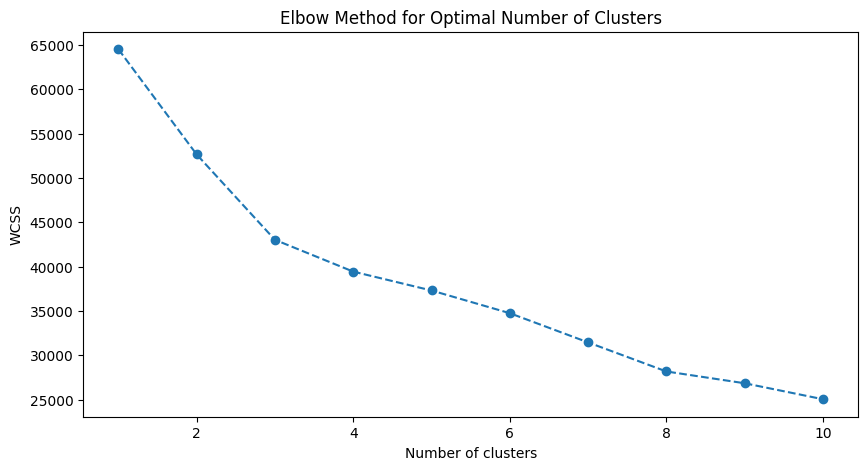

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming result_df is your DataFrame
features_df = result_df.drop(['id_student', 'final_result'], axis=1)

# Step 1: Preprocess the Data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

# Step 2: Determine the Optimal Number of Clusters using Elbow Method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=25252, max_iter=25252)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()




For n_clusters = 2, the average silhouette_score is : 0.5419447520224495
For n_clusters = 3, the average silhouette_score is : 0.5348290361016188
For n_clusters = 4, the average silhouette_score is : 0.40336831295048126
For n_clusters = 5, the average silhouette_score is : 0.33555295896882986
For n_clusters = 6, the average silhouette_score is : 0.34593903571100704
For n_clusters = 7, the average silhouette_score is : 0.31574123162022627
For n_clusters = 8, the average silhouette_score is : 0.4238023747950923
For n_clusters = 9, the average silhouette_score is : 0.4246947335818631
For n_clusters = 10, the average silhouette_score is : 0.3192574422263368


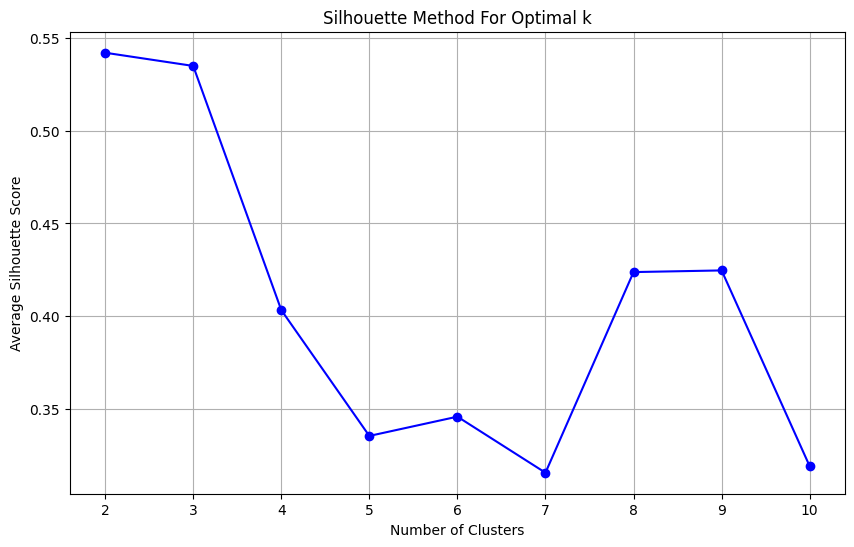

In [ ]:
from sklearn.metrics import silhouette_score

# Range of potential clusters
range_n_clusters = range(2, 11)  # Typically, start with 2 clusters

silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator seed for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=25252)
    cluster_labels = clusterer.fit_predict(features_scaled)
    
    # The silhouette_score gives the average value for all samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

# Plotting silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o', linestyle='-', color='b')
plt.title("Silhouette Method For Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Score")
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

In [97]:
import numpy as np

# Perform K-means Clustering with the optimal number found
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=25252, max_iter=30000)
clusters = kmeans.fit_predict(features_scaled)

# Add the cluster info back to the original dataframe
result_df['Cluster'] = clusters

# Show descriptive statistics of each cluster

# student count in each cluster
cluster_counts = result_df['Cluster'].value_counts().sort_index()
print(cluster_counts)



0     592
1    4320
2     465
Name: Cluster, dtype: int64


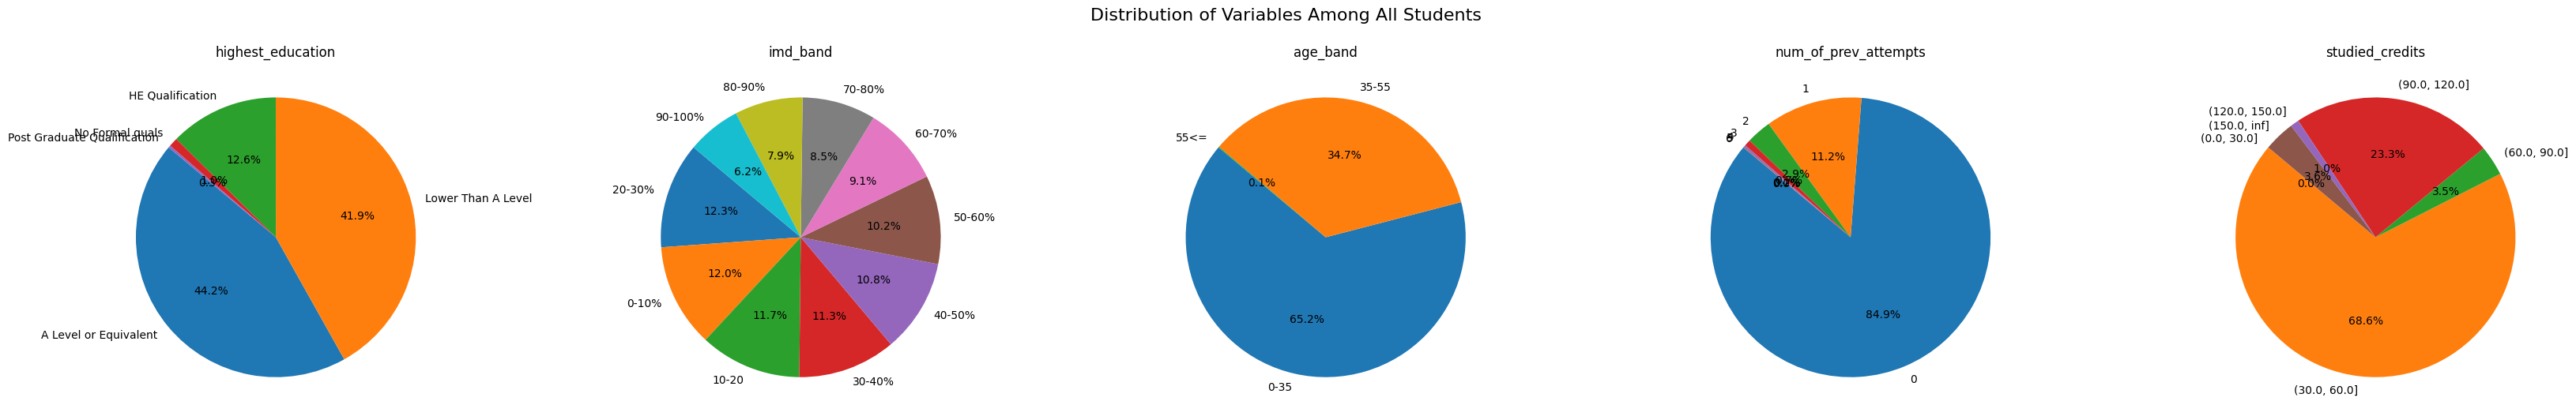

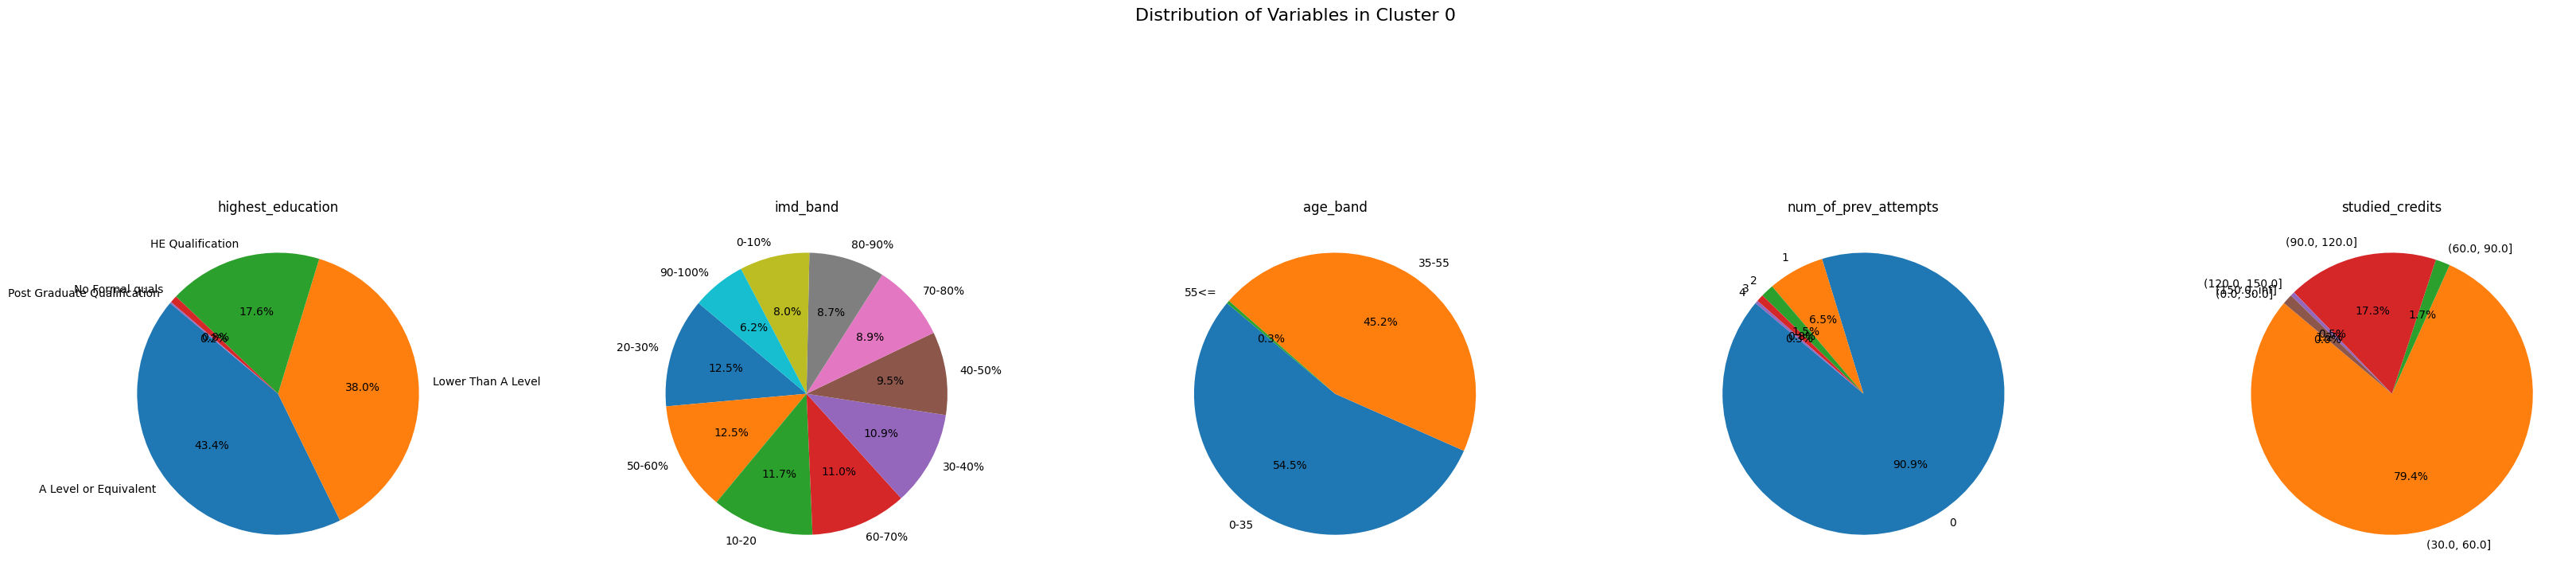

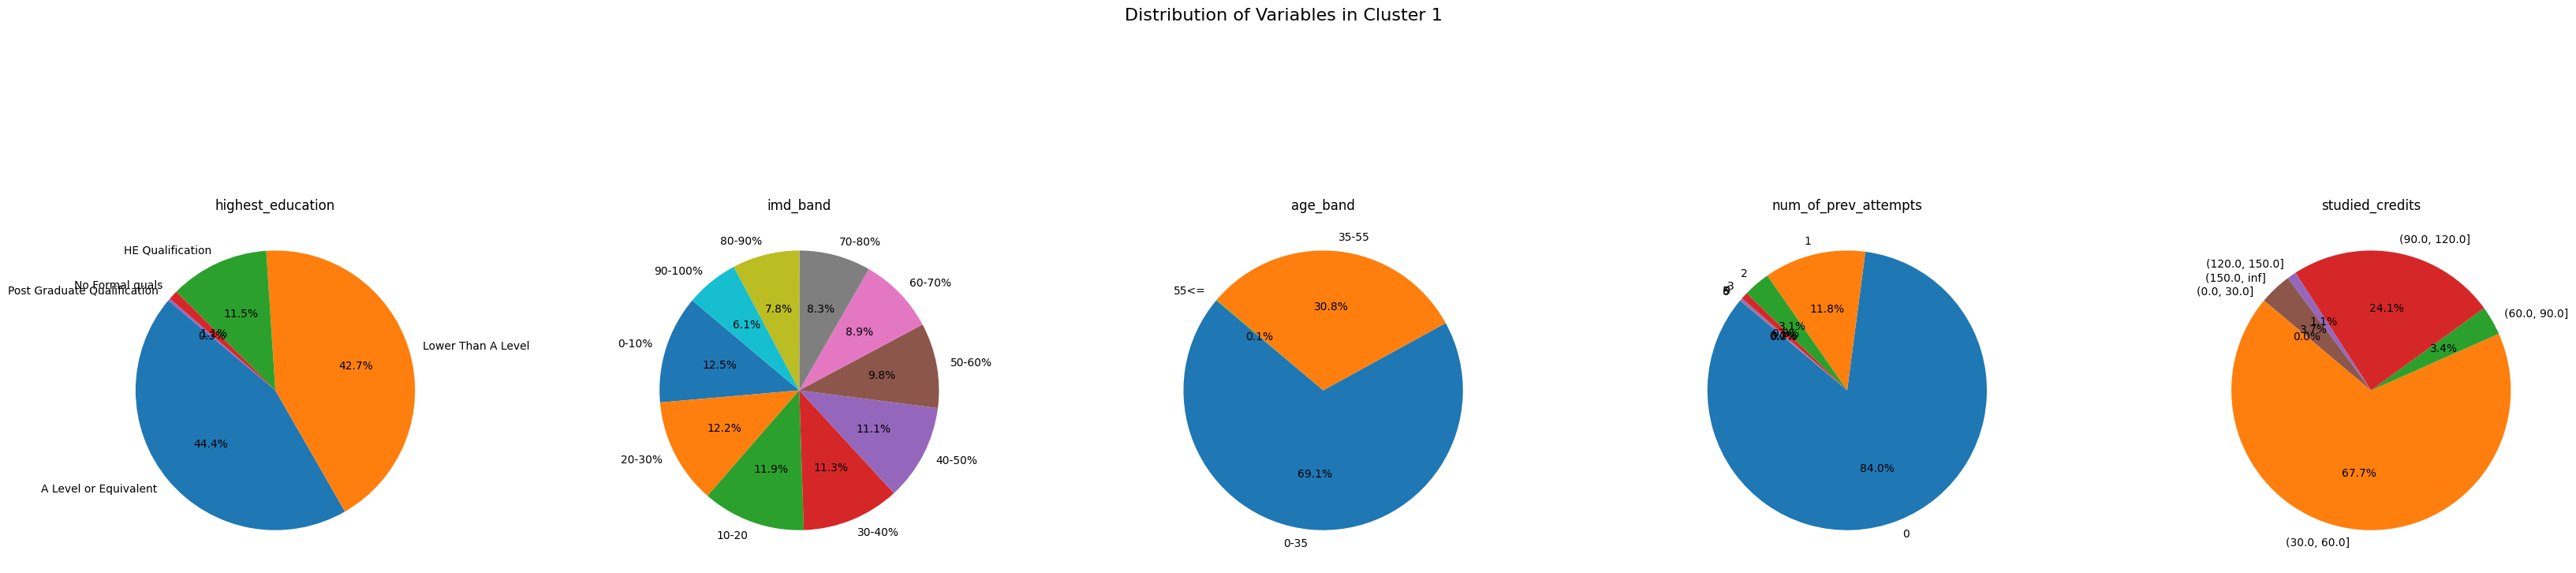

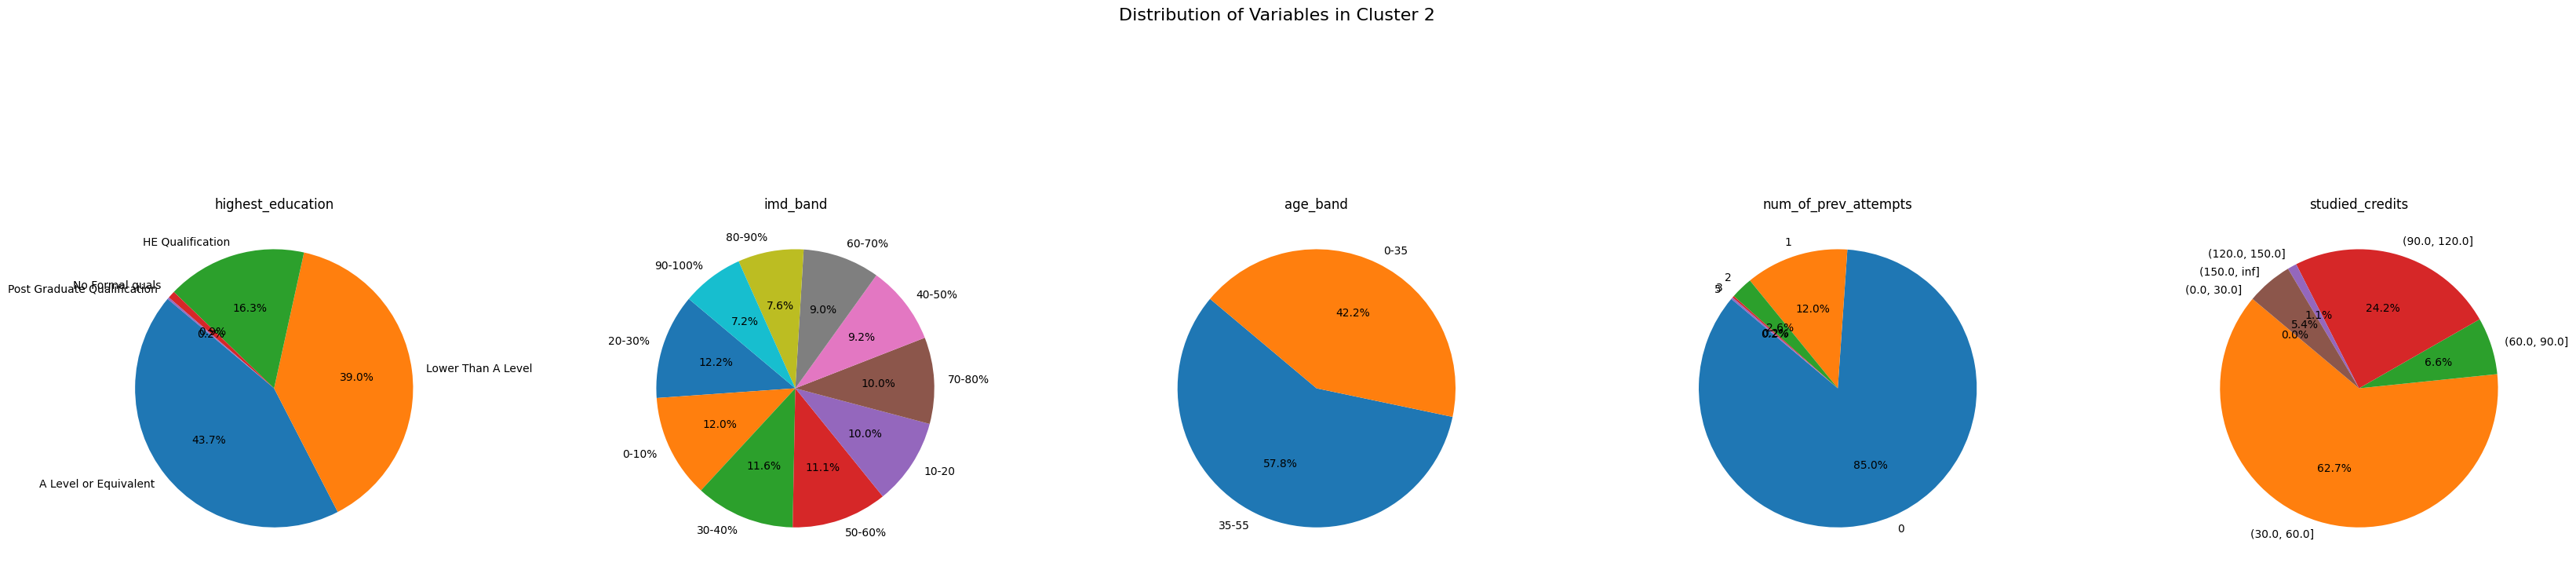

In [103]:
# result_df contains 'id_student' and 'Cluster' columns:
cluster_labels = result_df[['id_student', 'Cluster']]

# Merge the cluster labels with the studentInfo_df to include 'Cluster' column
student_info_clustered = pd.merge(student_info_df, cluster_labels, on='id_student', how='inner')

# Focus on the columns of interest
columns_of_interest = ['highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'Cluster']

# Filtered DataFrame for visualization
focused_df = student_info_clustered[columns_of_interest]

# Variables to create pie charts for
variables = ['highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits']

# Generate pie chart for the whole dataset
fig, axes = plt.subplots(1, len(variables), figsize=(40, 6))
fig.suptitle('Distribution of Variables Among All Students', fontsize=16)

for ax, var in zip(axes, variables):
        # For numeric variables ('num_of_prev_attempts', 'studied_credits'), we use value_counts() to get distribution
        if var in ['num_of_prev_attempts', 'studied_credits']:
            counts = student_info_clustered[var].value_counts().sort_index()
        # For categorical variables, directly use value_counts()
        else:
            counts = student_info_clustered[var].value_counts()
        
        # For variables with many unique values, consider binning or summarization before plotting
        if var == 'studied_credits':
            counts = pd.cut(student_info_clustered[var], bins=[0, 30, 60, 90, 120, 150, np.inf]).value_counts().sort_index()
        
        # Pie chart for the variable
        ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
        ax.set(aspect="equal", title=var)

plt.subplots_adjust(wspace=0.5)
plt.show()

# For each cluster, generate pie charts for each variable
clusters = focused_df['Cluster'].unique()
for cluster in sorted(clusters):
    # Filter the DataFrame for the current cluster
    cluster_df = focused_df[focused_df['Cluster'] == cluster]
    
    # Figure setup
    fig, axes = plt.subplots(1, len(variables), figsize=(40, 10))
    fig.suptitle(f'Distribution of Variables in Cluster {cluster}', fontsize=16)
    
    for ax, var in zip(axes, variables):
        # For numeric variables ('num_of_prev_attempts', 'studied_credits'), we use value_counts() to get distribution
        if var in ['num_of_prev_attempts', 'studied_credits']:
            counts = cluster_df[var].value_counts().sort_index()
        # For categorical variables, directly use value_counts()
        else:
            counts = cluster_df[var].value_counts()
        
        # For variables with many unique values, consider binning or summarization before plotting
        if var == 'studied_credits':
            counts = pd.cut(cluster_df[var], bins=[0, 30, 60, 90, 120, 150, np.inf]).value_counts().sort_index()
        
        # Pie chart for the variable
        ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
        ax.set(aspect="equal", title=var)

    plt.subplots_adjust(wspace=0.5)
    plt.show()


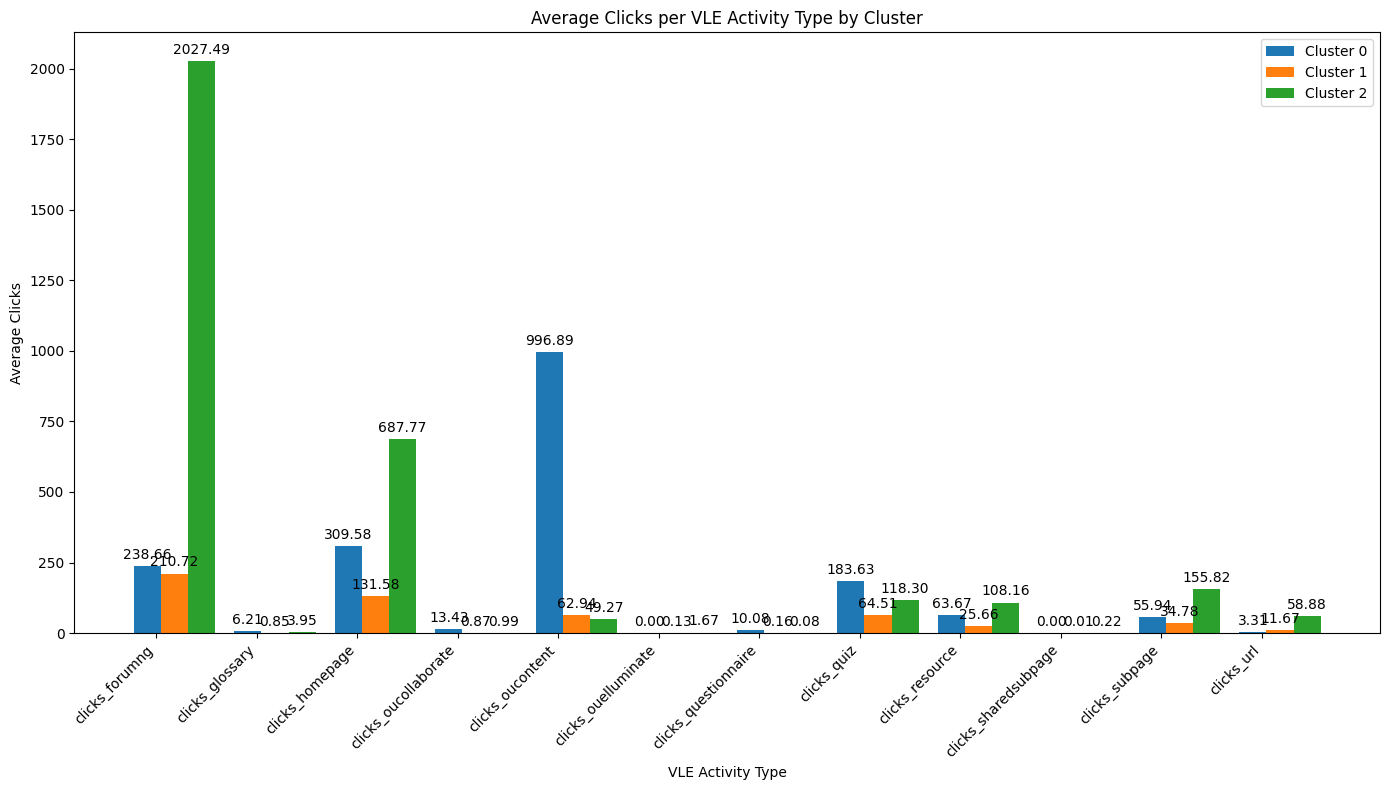

In [54]:
import matplotlib.pyplot as plt

# Given cluster_means containing the average clicks per activity type (excluding 'id_student')
# First, ensure the cluster_means is reset if it was previously modified and has a column for Cluster
cluster_means = result_df.drop(['id_student', 'final_result'], axis=1).groupby('Cluster').mean()

# Transpose cluster_means to make it easier for plotting
data_transposed = cluster_means.transpose()

# Set up the x locations for the groups
n = len(data_transposed)  # Number of activity types
ind = np.arange(n)  # the x locations for the groups
width = 0.27  # the width of the bars

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# Create bars for each cluster
bars = []
for i in range(len(cluster_means)):
    bars.append(ax.bar(ind + i*width, data_transposed[i], width, label=f'Cluster {i}'))

# Add some text for labels, title and axes ticks
ax.set_xlabel('VLE Activity Type')
ax.set_ylabel('Average Clicks')
ax.set_title('Average Clicks per VLE Activity Type by Cluster')
ax.set_xticks(ind + width / 3)
ax.set_xticklabels(data_transposed.index, rotation=45, ha="right")

ax.legend(loc='best')

# Adding value labels on top of each bar
for bar in bars:
    for rect in bar:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

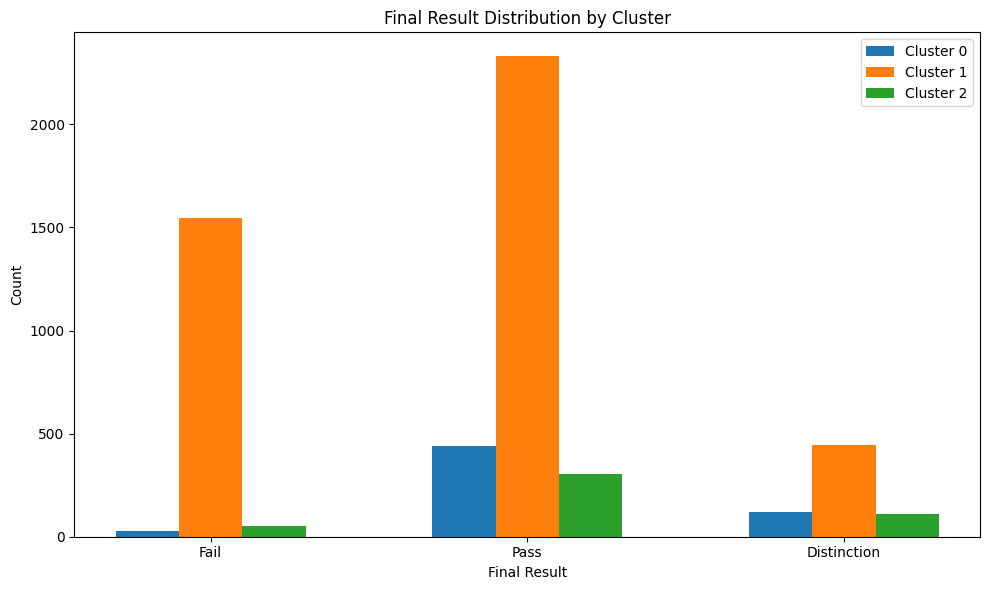

In [55]:
# Prepare Data
final_result_counts = result_df.groupby(['Cluster', 'final_result']).size().unstack(fill_value=0).reindex(columns=["Fail", "Pass", "Distinction"])

# Parameters for the grouped bar chart
n_clusters = len(final_result_counts.index)
n_results = len(final_result_counts.columns)
index = np.arange(n_results)
bar_width = 0.2

# Create the plot
plt.figure(figsize=(10, 6))
for i, cluster in enumerate(final_result_counts.index):
    plt.bar(index + i*bar_width, final_result_counts.loc[cluster], bar_width, label=f'Cluster {cluster}')

plt.xlabel('Final Result')
plt.ylabel('Count')
plt.title('Final Result Distribution by Cluster')
plt.xticks(index + bar_width, final_result_counts.columns)
plt.legend()

plt.tight_layout()
plt.show()

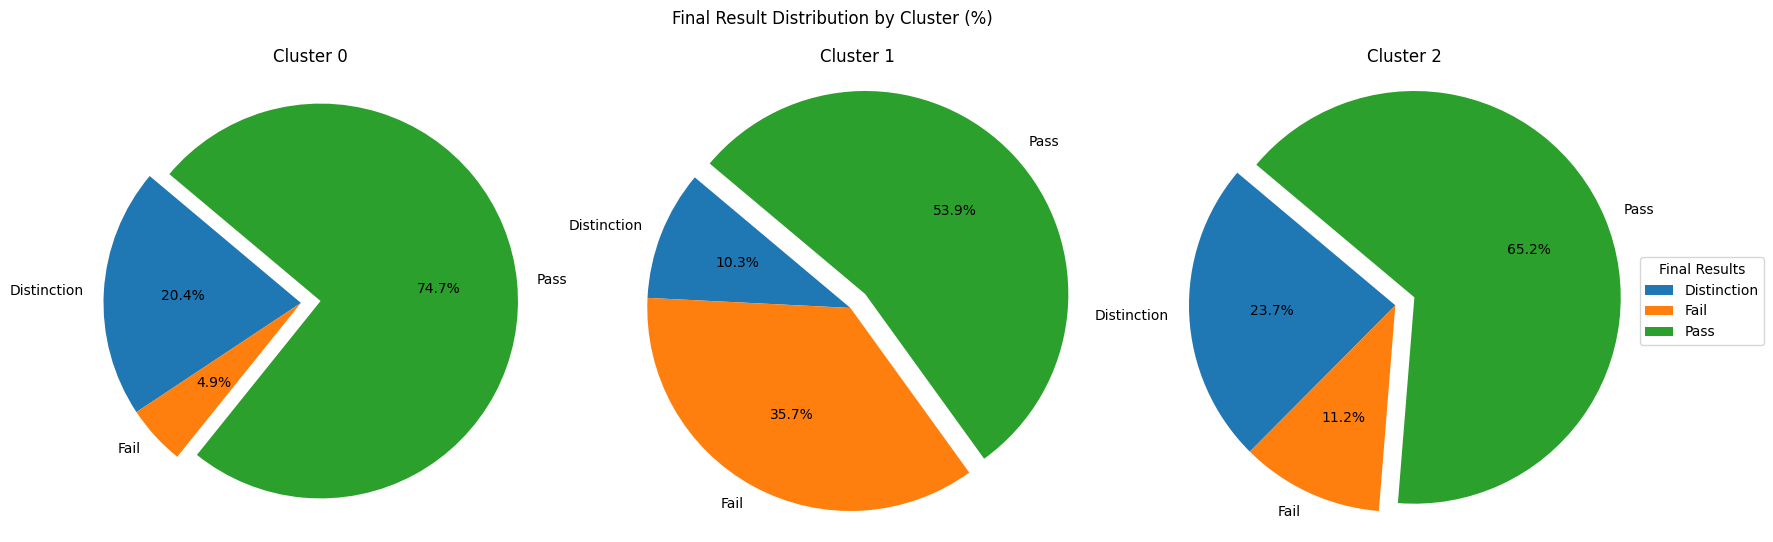

In [56]:
# Calculate the counts and percentages as before
final_result_counts = result_df.groupby(['Cluster', 'final_result']).size().unstack(fill_value=0)
final_result_percentages = final_result_counts.div(final_result_counts.sum(axis=1), axis=0) * 100

clusters = final_result_counts.index

# Create a pie chart for each cluster
fig, axes = plt.subplots(1, len(clusters), figsize=(20, 6), subplot_kw=dict(aspect="equal"))
fig.suptitle('Final Result Distribution by Cluster (%)')

for ax, cluster in zip(axes, clusters):
    sizes = final_result_percentages.loc[cluster].values
    labels = final_result_percentages.columns
    explode = [0.1 if max(sizes) == size else 0 for size in sizes]  # Explode the largest slice
    
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode)
    
    ax.set_title(f'Cluster {cluster}')
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

plt.legend(wedges, labels, title="Final Results", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

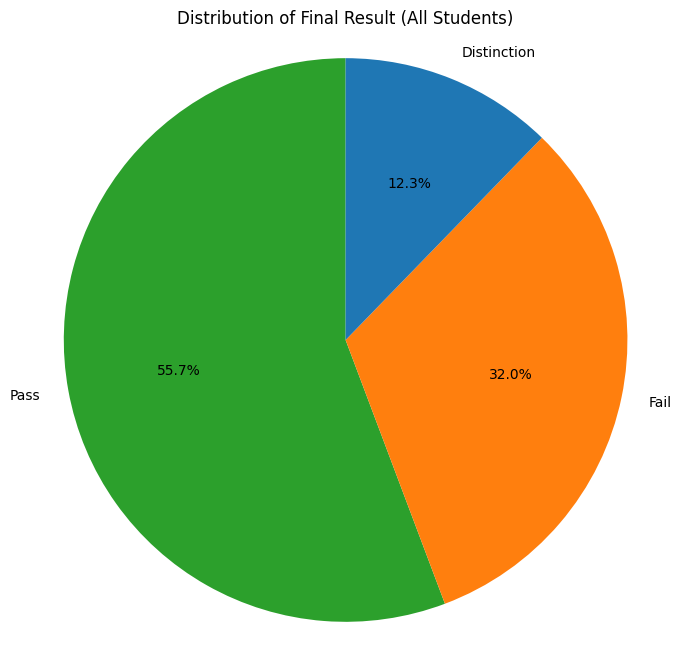

In [105]:
# Calculate the distribution of final results
final_result_distribution = student_info_df['final_result'].value_counts()

# Pie chart
plt.figure(figsize=(8, 8))

# Blue for distinction, green for pass, orange for fail
colors = ['tab:green', 'tab:orange', 'tab:blue', ]

plt.pie(final_result_distribution, labels=final_result_distribution.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Final Result (All Students)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

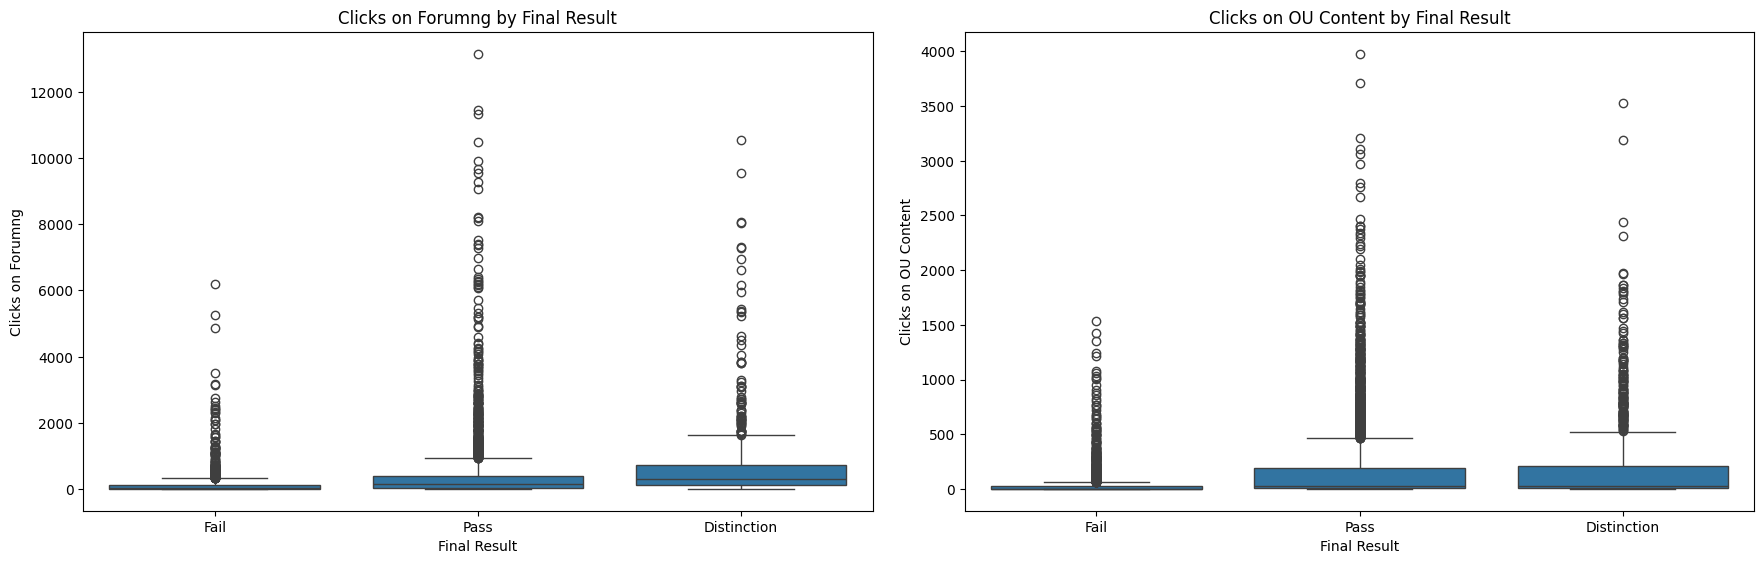

In [58]:
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot clicks_forumng
sns.boxplot(ax=axes[0], x='final_result', y='clicks_forumng', data=result_df, order=["Fail", "Pass", "Distinction"], )
axes[0].set_title('Clicks on Forumng by Final Result')
axes[0].set_xlabel('Final Result')
axes[0].set_ylabel('Clicks on Forumng')

# Plot clicks_oucontent
sns.boxplot(ax=axes[1], x='final_result', y='clicks_oucontent', data=result_df, order=["Fail", "Pass", "Distinction"])
axes[1].set_title('Clicks on OU Content by Final Result')
axes[1].set_xlabel('Final Result')
axes[1].set_ylabel('Clicks on OU Content')

# Fine-tune figure; make subplots close to each other and hide x labels for all but bottom plot.
fig.tight_layout(pad=2.0)
plt.show()

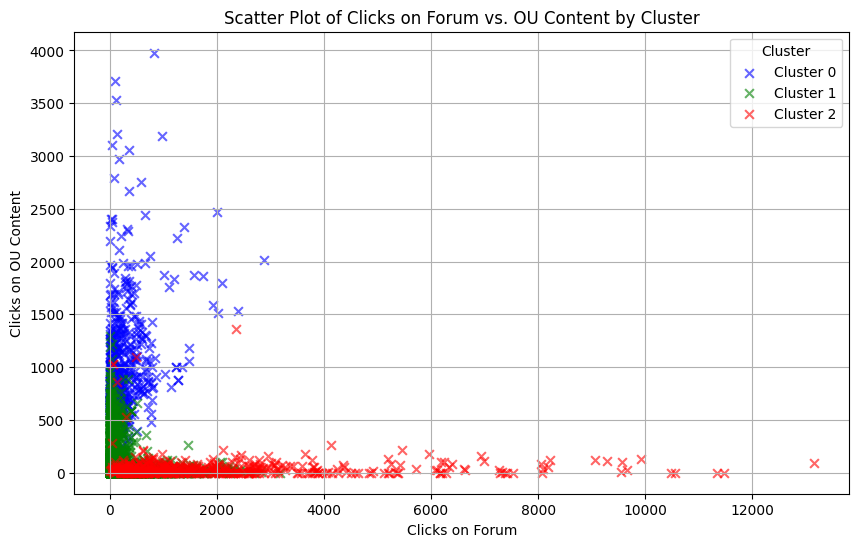

In [59]:
plt.figure(figsize=(10, 6))

# Define a color map for clusters
color_map = {0: 'blue', 1: 'green', 2: 'red'}

# Plot each cluster with a loop to control colors, markers, and add transparency
for cluster in sorted(result_df['Cluster'].unique()):
    # Filter the dataframe by cluster
    cluster_df = result_df[result_df['Cluster'] == cluster]
    # Plotting with transparency
    plt.scatter(cluster_df['clicks_forumng'], cluster_df['clicks_oucontent'], 
                s=40,  # Size of the cross markers
                c=color_map[cluster],  # Color based on cluster
                marker='x',  # Cross marker
                label=f'Cluster {cluster}',  # Label for legend
                alpha=0.6)  # Transparency of markers

plt.title('Scatter Plot of Clicks on Forum vs. OU Content by Cluster')
plt.xlabel('Clicks on Forum')
plt.ylabel('Clicks on OU Content')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

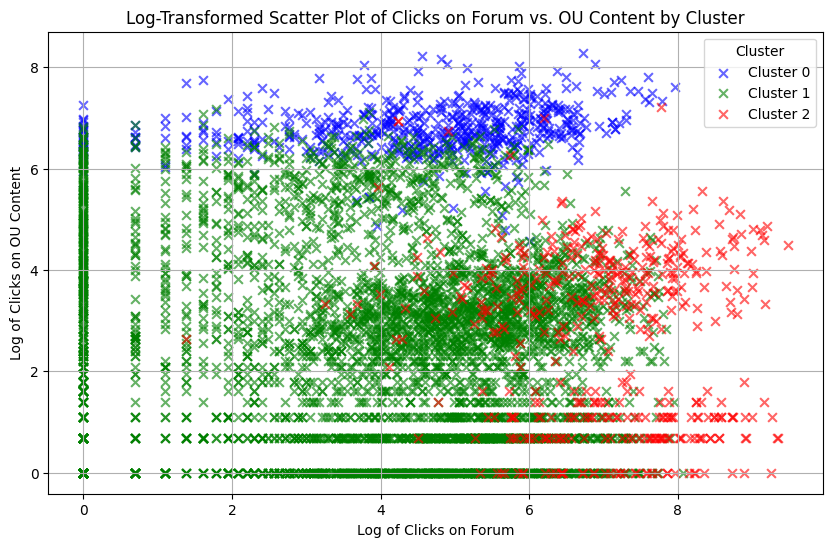

In [60]:
# Add a small constant to avoid taking log of 0
small_constant = 1

# Apply logarithmic transformation, adding 1 to avoid log(0)
log_forumng = np.log(result_df['clicks_forumng'] + small_constant)
log_oucontent = np.log(result_df['clicks_oucontent'] + small_constant)

plt.figure(figsize=(10, 6))

# Define a color map for clusters
color_map = {0: 'blue', 1: 'green', 2: 'red'}

# Plot each cluster with a loop to control colors, markers, and add transparency
for cluster in sorted(result_df['Cluster'].unique()):
    # Filter the dataframe by cluster
    cluster_df = result_df[result_df['Cluster'] == cluster]
    
    # Plotting log-transformed data with transparency
    plt.scatter(np.log(cluster_df['clicks_forumng'] + small_constant), 
                np.log(cluster_df['clicks_oucontent'] + small_constant), 
                s=40,  # Size of the cross markers
                color=color_map[cluster],  # Color based on cluster
                marker='x',  # Cross marker
                label=f'Cluster {cluster}',  # Label for legend
                alpha=0.6)  # Transparency of markers

plt.title('Log-Transformed Scatter Plot of Clicks on Forum vs. OU Content by Cluster')
plt.xlabel('Log of Clicks on Forum')
plt.ylabel('Log of Clicks on OU Content')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [109]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Example activity types
activity_types = ['clicks_forumng', 'clicks_homepage', 
                  'clicks_oucontent', 'clicks_quiz']

# Categorizing clicks into 'low', 'medium', 'high' bins
for activity in activity_types:
    result_df[activity + '_cat'] = pd.qcut(result_df[activity], q=[0, .33, .67, 1], labels=["low", "medium", "high"], duplicates='drop')

bin_edges = {}  # To store bin edges for each activity_type

for activity in activity_types:
    try:
        # Attempt to divide into quantiles while also capturing the bin edges
        _, bins = pd.qcut(result_df[activity], q=[0, .33, .67, 1], duplicates="drop", retbins=True)
        bin_edges[activity] = bins
        print(f"Bin edges for {activity}: {bins}")
    except ValueError as e:
        # In case of insufficient diversity to create bins
        print(f"Could not compute quantile-based bins for {activity} due to: {e}")
        # Log unique values for manual inspection
        unique_vals = np.sort(result_df[activity].unique())
        print(f"Unique values for {activity}: {unique_vals[:min(len(unique_vals),10)]}...")  # Print first few unique values

# Optionally, proceed with manual binning for activities that failed automatic binning
# E.g., manually inspecting unique values and defining bins based on domain knowledge or observed distribution

# Add final result to the activity types for generating rules based on final result
activity_types_with_result = activity_types + ['final_result']

# Transforming the dataframe to list of lists
student_activities = []
for i, row in result_df.iterrows():
    student_activity = []
    for activity in activity_types:
        student_activity.append(f"{activity}_{row[activity + '_cat']}")
    student_activity.append(f"Result_{row['final_result']}")
    student_activities.append(student_activity)

# Encode the data into a format suitable for the mlxtend implementation of Apriori
te = TransactionEncoder()
te_ary = te.fit(student_activities).transform(student_activities)
df = pd.DataFrame(te_ary, columns=te.columns_)

df.to_csv('student_activities_encoded.csv', index=False)

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

# Filter rules based on the consequence being a final result
rules_final_result = rules[rules['consequents'].apply(lambda x: "Result_" in list(x)[0])]
print(rules_final_result[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# output the rules to a CSV file
rules_final_result.to_csv('association_rules.csv', index=False)

Bin edges for clicks_forumng: [    0.    43.   240. 13154.]
Bin edges for clicks_homepage: [   0.   81.  201. 4120.]
Bin edges for clicks_oucontent: [   0.    4.   43. 3978.]
Bin edges for clicks_quiz: [  0.  62.  91. 950.]
                                           antecedents  \
0                                 (clicks_forumng_low)   
2                                (clicks_homepage_low)   
4                               (clicks_oucontent_low)   
7                                    (clicks_quiz_low)   
9                                (clicks_forumng_high)   
10                                (clicks_forumng_low)   
13                             (clicks_forumng_medium)   
14                              (clicks_homepage_high)   
16                               (clicks_homepage_low)   
18                            (clicks_homepage_medium)   
20                             (clicks_oucontent_high)   
22                              (clicks_oucontent_low)   
25                    